![title](../images/header.png)

Merge all CEO for drivers analysis 2015-2023
-------
This notebook merges all validated data from different CEO CAFI projects for all years and determines the relative driver contribution
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Set the display option to a large value to prevent text wrapping
pd.set_option('display.max_colwidth', None)

### 1. Read all CEO sample files
download your CEO sample files from collect.earth and upload to SEPAL using FileZilla.
add as many files as you have projects

In [2]:
ceo1 = pd.read_csv('/home/sepal-user/module_results/esbae/CAR/CAR_all_ceo_2015_2022_2023_prov_eSBAE_TNT.csv',low_memory=False)
ceo2 = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_all_ceo_2015_2022_2023_prov_eSBAE_TNT.csv',low_memory=False)
ceo3 = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_all_ceo_2015_2016_2023_prov_eSBAE_TNT_update.csv',low_memory=False)
ceo4 = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/CMR_all_ceo_2015_2022_2023_prov_eSBAE_TNT.csv',low_memory=False)
ceo5 = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_all_ceo_2015_2022_2023_prov_eSBAE_TNT.csv',low_memory=False)
ceo6 = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_all_ceo_2015_2022_2023_prov_eSBAE_TNT.csv',low_memory=False)
ceo7 = pd.read_csv('/home/sepal-user/module_results/esbae/CAFI/CAFI_ceo_1520_clean_CAFsubadmin.csv', low_memory=False)
ceo8 = pd.read_csv('/home/sepal-user/module_results/esbae/CAFI/CAFI_ceo_1520_clean_CMRsubadmin.csv', low_memory=False)
ceo9 = pd.read_csv('/home/sepal-user/module_results/esbae/CAFI/CAFI_ceo_1520_clean_CODsubadmin.csv', low_memory=False)
ceo10 = pd.read_csv('/home/sepal-user/module_results/esbae/CAFI/CAFI_ceo_1520_clean_COGsubadmin.csv', low_memory=False)
ceo11 = pd.read_csv('/home/sepal-user/module_results/esbae/CAFI/CAFI_ceo_1520_clean_EQGsubadmin.csv', low_memory=False)
ceo12 = pd.read_csv('/home/sepal-user/module_results/esbae/CAFI/CAFI_ceo_1520_clean_GABsubadmin.csv', low_memory=False)

In [3]:
ceo1['ISO'] = 'CAF'
ceo2['ISO'] = 'COD'
ceo3['ISO'] = 'COG'
ceo4['ISO'] = 'CMR'
ceo5['ISO'] = 'EQG'
ceo6['ISO'] = 'GAB'

In [4]:
output_drivers = '/home/sepal-user/module_results/esbae/CAFI/CAFI_DDD_all_ceo_2015_2023.csv'

In [5]:
len(ceo2)

22118

In [6]:
len(ceo1)

6055

##### align columns for COG

In [7]:
ceo3.head()

,geometry,UID_1,TNT_stratum_2023,UID,ID,plotid,point_id,sampleid,lon,lat,sample_geom,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_Year_1522,Ref_NFtype_2015,Ref_Ftype_2015,collection,interpreted,Ref_LCover_2015,Ref_Change_Year_1522,Ref_Change_LCover_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,Stable,NF,DensFor,DensDryFor,SecFor,DryOpenFor,Mangrove,Swamp,Gallery,Plantation,Woodland,Shrubland,Grassland,Aquatic,Bare,Cultivated,Builtup,Water,DensFor_Def,DensDryFor_Def,SecFor_Def,DryOpenFor_Def,Mangrove_Def,Swamp_Def,Gallery_Def,Plantation_Def,Woodland_Def,DensFor_Deg,DensDryFor_Deg,SecFor_Deg,DryOpenFor_Deg,Mangrove_Deg,Swamp_Deg,Gallery_Deg,Plantation_Deg,Woodland_Deg,DensFor_Stable,DensDryFor_Stable,SecFor_Stable,DryOpenFor_Stable,Mangrove_Stable,Swamp_Stable,Gallery_Stable,Plantation_Stable,Woodland_Stable,ISO,sampling,Ref_FNF_2016,Ref_NFtype_2016,Ref_Ftype_2016,Ref_Change_1622,Ref_Change_Type_1622,Ref_Year_1622,Ref_Driver_1622,Ref_Fire_1622,Ref_Change2_1622,Ref_Change2_Type_1622,Ref_Driver2_1622,Ref_Fire2_1622,Other2,Ref_Regen_Year,Ref_FNF_2022,Ref_NFtype_2022,Ref_Ftype_2022,Commentaires,Ref_LCover_2016,Ref_Change_Year_1622,Ref_Change_LCover_1622,ID.1,sample_internal_id,collection_time,Ref_FNF_2023,Ref_NFtype_2023,Ref_Ftype_2023,Ref_Change_2023,Ref_Change_Year,Ref_Change_Type_2023,Ref_Driver1_2023,Ref_Fire_2023,Ref_Change2_2023,Ref_Change2_Type_2023,Ref_Driver2_2023,Ref_Fire2_2023,Ref_LCover_2022,Ref_Change_Year_2023,Ref_Change_LCover_2023,Def2023,Deg2023,interpreted_qc,eSBAE_strat_1522,Departement,Ref_Year_2023
0,POINT (11.279983 -3.903345),1,1,0,0,542426,542426.0,542426,11.279983,-3.903345,POINT(11.279983 -3.903345),1,NaN,0.0,Stable,0.0,0.0,0.0,0.0,0.0,0,NaN,0.0,0.0,0.0,NaN,NaN,1.0,coll_1522_1,1,1,Stable,Stable_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,COG,ceo_1522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Kouilou,NaN
1,POINT (12.605415 -4.298105),2,1,1,1,1016750,1016750.0,1016750,12.605415,-4.298105,POINT(12.605415 -4.298105),1,NaN,0.0,Stable,0.0,0.0,0.0,0.0,0.0,0,NaN,0.0,0.0,0.0,NaN,NaN,1.0,coll_1522_1,1,1,Stable,Stable_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,COG,ceo_1522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Kouilou,NaN
2,POINT (12.605014 -4.182788),3,1,2,2,1016273,1016273.0,1016273,12.605014,-4.182788,POINT(12.605014 -4.182788),1,non,0.0,NF,0.0,0.0,0.0,0.0,0.0,0,NaN,0.0,0.0,0.0,NaN,17.0,NaN,coll_1522_1,1,17,NF,NF_17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,COG,ceo_1522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Niari,NaN
3,POINT (12.568966 -3.865546),4,1,3,3,1015146,1015146.0,1015146,12.568966,-3.865546,POINT(12.568966 -3.865546),1,oui,0.0,NF,0.0,0.0,0.0,0.0,0.0,0,NaN,0.0,0.0,0.0,NaN,15.0,NaN,coll_1522_1,1,15,NF,NF_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,COG,ceo_1522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,Niari,NaN
4,POINT (17.626291 2.90407),5,1,4,4,1006758,1006758.0,1006758,17.626291,2.904

In [8]:
print(ceo3.dtypes)

geometry                   object
UID_1                       int64
TNT_stratum_2023            int64
UID                         int64
ID                          int64
plotid                      int64
point_id                  float64
sampleid                    int64
lon                       float64
lat                       float64
sample_geom                object
Ref_FNF_2015                int64
Ref_Regeneration           object
Ref_Change_1522           float64
Ref_Change_Type_1522       object
ArtFor                    float64
ArtMine                   float64
InfraR                    float64
Urb                       float64
IndFor                    float64
Other                      object
Other_Desc                 object
IndMine                   float64
IndAg                     float64
ArtAg                     float64
Ref_Year_1522             float64
Ref_NFtype_2015           float64
Ref_Ftype_2015            float64
collection                 object
interpreted   

In [9]:
ceo3.rename(columns={'Departement': 'Province_COG'}, inplace=True)

In [10]:
ceo3['Ref_Driver1_2023'].value_counts()

Ref_Driver1_2023
agriculture paysanne          22
autres                         8
foresterie artisanale <5ha     6
infrastructure routière        3
Name: count, dtype: int64

In [11]:
ceo3.loc[ceo3['Ref_Driver_1622'] == 'agriculture paysanne', 'ArtAg'] = 1
ceo3.loc[ceo3['Ref_Driver_1622'] == 'foresterie artisanale <5ha', 'ArtFor'] = 1
ceo3.loc[ceo3['Ref_Driver_1622'] == 'foresterie industrielle >5ha', 'IndFor'] = 1
ceo3.loc[ceo3['Ref_Driver_1622'] == 'infrastructure routière', 'InfraR'] = 1
ceo3.loc[ceo3['Ref_Driver_1622'] == 'urbanisation / habitation', 'Urb'] = 1
ceo3.loc[ceo3['Ref_Driver_1622'] == 'agriculture industrielle', 'IndAg'] = 1
ceo3.loc[ceo3['Ref_Driver_1622'] == 'act. miniere artisanale', 'ArtMine'] = 1
ceo3.loc[ceo3['Ref_Driver_1622'] == 'act. minière industrielle', 'IndMine'] = 1
ceo3.loc[ceo3['Ref_Driver_1622'] == 'autres', 'Other'] = 1

In [12]:
ceo3.loc[ceo3['Ref_Driver2_1622'] == 'agriculture paysanne', 'ArtAg'] = 1
ceo3.loc[ceo3['Ref_Driver2_1622'] == 'foresterie artisanale <5ha', 'ArtFor'] = 1
ceo3.loc[ceo3['Ref_Driver2_1622'] == 'foresterie industrielle >5ha', 'IndFor'] = 1
ceo3.loc[ceo3['Ref_Driver2_1622'] == 'infrastructure routière', 'InfraR'] = 1
ceo3.loc[ceo3['Ref_Driver2_1622'] == 'urbanisation / habitation', 'Urb'] = 1
ceo3.loc[ceo3['Ref_Driver2_1622'] == 'agriculture industrielle', 'IndAg'] = 1
ceo3.loc[ceo3['Ref_Driver2_1622'] == 'act. miniere artisanale', 'ArtMine'] = 1
ceo3.loc[ceo3['Ref_Driver2_1622'] == 'act. minière industrielle', 'IndMine'] = 1
ceo3.loc[ceo3['Ref_Driver2_1622'] == 'autres', 'Other'] = 1

In [13]:
ceo3.loc[ceo3['Ref_Driver1_2023'] == 'agriculture paysanne', 'ArtAg'] = 1
ceo3.loc[ceo3['Ref_Driver1_2023'] == 'foresterie artisanale <5ha', 'ArtFor'] = 1
ceo3.loc[ceo3['Ref_Driver1_2023'] == 'foresterie industrielle >5ha', 'IndFor'] = 1
ceo3.loc[ceo3['Ref_Driver1_2023'] == 'infrastructure routière', 'InfraR'] = 1
ceo3.loc[ceo3['Ref_Driver1_2023'] == 'urbanisation / habitation', 'Urb'] = 1
ceo3.loc[ceo3['Ref_Driver1_2023'] == 'agriculture industrielle', 'IndAg'] = 1
ceo3.loc[ceo3['Ref_Driver1_2023'] == 'act. miniere artisanale', 'ArtMine'] = 1
ceo3.loc[ceo3['Ref_Driver1_2023'] == 'act. minière industrielle', 'IndMine'] = 1
ceo3.loc[ceo3['Ref_Driver1_2023'] == 'autres', 'Other'] = 1

In [14]:
ceo3.loc[ceo3['Ref_Driver2_2023'] == 'agriculture paysanne', 'ArtAg'] = 1
ceo3.loc[ceo3['Ref_Driver2_2023'] == 'foresterie artisanale <5ha', 'ArtFor'] = 1
ceo3.loc[ceo3['Ref_Driver2_2023'] == 'foresterie industrielle >5ha', 'IndFor'] = 1
ceo3.loc[ceo3['Ref_Driver2_2023'] == 'infrastructure routière', 'InfraR'] = 1
ceo3.loc[ceo3['Ref_Driver2_2023'] == 'urbanisation / habitation', 'Urb'] = 1
ceo3.loc[ceo3['Ref_Driver2_2023'] == 'agriculture industrielle', 'IndAg'] = 1
ceo3.loc[ceo3['Ref_Driver2_2023'] == 'act. miniere artisanale', 'ArtMine'] = 1
ceo3.loc[ceo3['Ref_Driver2_2023'] == 'act. minière industrielle', 'IndMine'] = 1
ceo3.loc[ceo3['Ref_Driver2_2023'] == 'autres', 'Other'] = 1

In [15]:
ceo3['IndMine'].value_counts()

IndMine
0.0    412
Name: count, dtype: int64

In [16]:
ceo3['Other'].value_counts()

Other
0    409
1     25
1      3
Name: count, dtype: int64

In [17]:
ceo3['Ref_LCover_2016'].value_counts()

Ref_LCover_2016
1.0     1227
13.0    1182
3.0     1138
12.0    1032
16.0     260
8.0      206
9.0      181
18.0     160
14.0     110
15.0      96
4.0       65
17.0      40
10.0      21
7.0        3
Name: count, dtype: int64

In [18]:
columns_to_convert = ['ArtFor','ArtMine','IndMine', 'IndFor','InfraR','Urb','ArtAg','IndAg','Other']
ceo1.loc[:,columns_to_convert] = ceo1[columns_to_convert].astype(float).fillna(0).astype(int)
ceo2.loc[:,columns_to_convert] = ceo2[columns_to_convert].astype(float).fillna(0).astype(int)
ceo3.loc[:,columns_to_convert] = ceo3[columns_to_convert].astype(float).fillna(0).astype(int)
ceo4.loc[:,columns_to_convert] = ceo4[columns_to_convert].astype(float).fillna(0).astype(int)
ceo5.loc[:,columns_to_convert] = ceo5[columns_to_convert].astype(float).fillna(0).astype(int)
ceo6.loc[:,columns_to_convert] = ceo6[columns_to_convert].astype(float).fillna(0).astype(int)
ceo7.loc[:,columns_to_convert] = ceo7[columns_to_convert].astype(float).fillna(0).astype(int)
ceo8.loc[:,columns_to_convert] = ceo8[columns_to_convert].astype(float).fillna(0).astype(int)
ceo9.loc[:,columns_to_convert] = ceo9[columns_to_convert].astype(float).fillna(0).astype(int)
ceo10.loc[:,columns_to_convert] = ceo10[columns_to_convert].astype(float).fillna(0).astype(int)
ceo11.loc[:,columns_to_convert] = ceo11[columns_to_convert].astype(float).fillna(0).astype(int)
ceo12.loc[:,columns_to_convert] = ceo12[columns_to_convert].astype(float).fillna(0).astype(int)

##### combine all ceo files

In [19]:
# Concatenate DataFrames
combined_ceo = pd.concat([ceo1, ceo2, ceo3, ceo4, ceo5, ceo6,ceo7,ceo8,ceo9,ceo10,ceo11,ceo12], axis=0, ignore_index=True)

In [20]:
len(combined_ceo)

76051

In [21]:
combined_ceo['ISO'].value_counts(dropna=False)

ISO
COD    28529
CMR    12296
GAB    11439
COG    10046
CAF     8380
EQG     5361
Name: count, dtype: int64

In [22]:
combined_ceo.columns.tolist()

['geometry',
 'UID',
 'TNT_stratum_2023',
 'ID',
 'plotid',
 'point_id',
 'sampleid',
 'lon',
 'lat',
 'sample_geom',
 'Ref_FNF_2015',
 'Ref_Regeneration',
 'Ref_Change_1522',
 'Ref_Change_Type_1522',
 'ArtFor',
 'ArtMine',
 'InfraR',
 'Urb',
 'IndFor',
 'Other',
 'Other_Desc',
 'IndMine',
 'IndAg',
 'ArtAg',
 'Ref_Year_1522',
 'Ref_NFtype_2015',
 'Ref_Ftype_2015',
 'collection',
 'interpreted',
 'Ref_LCover_2015',
 'Ref_Change_Year_1522',
 'Ref_Change_LCover_1522',
 'Def2016',
 'Def2017',
 'Def2018',
 'Def2019',
 'Def2020',
 'Def2021',
 'Def2022',
 'Deg2016',
 'Deg2017',
 'Deg2018',
 'Deg2019',
 'Deg2020',
 'Deg2021',
 'Deg2022',
 'Defall',
 'Degall',
 'Stable',
 'NF',
 'DensFor',
 'DensDryFor',
 'SecFor',
 'DryOpenFor',
 'Mangrove',
 'Swamp',
 'Gallery',
 'Plantation',
 'Woodland',
 'Shrubland',
 'Grassland',
 'Aquatic',
 'Bare',
 'Cultivated',
 'Builtup',
 'Water',
 'DensFor_Def',
 'DensDryFor_Def',
 'SecFor_Def',
 'DryOpenFor_Def',
 'Mangrove_Def',
 'Swamp_Def',
 'Gallery_Def',
 'P

In [23]:
# List of columns to drop
columns_to_drop = ['DensFor_Stable', 'DensDryFor_Stable',
 'SecFor_Stable', 'DryOpenFor_Stable',
 'Mangrove_Stable', 'Swamp_Stable',
 'Gallery_Stable', 'Plantation_Stable',
 'Woodland_Stable', 'ID',
 'plotid', 'point_id',
 'sampleid', 'sample_geom',
 'Ref_Fire_2023', 'Ref_Change2_2023',
 'Ref_Change2_Type_2023',
 'Ref_Driver2_2023',
 'Ref_Fire2_2023', 'Ref_Change_LCover_2023',
 'sample_internal_id',
 'collection_time',
 'whisp2023',
 'whisp_UID',
 'whisp_ceo_UID', 
 'eSBAE_strat_1522',
 'Index',
 'Plot_ID',
 'UID_1',
 'whisp2023',
 'whisp_UID',
 'Ref_Fire_2023',
 'Ref_Change2_2023',
 'Ref_Change2_Type_2023',
 'Ref_Driver2_2023',
 'Ref_Fire2_2023',
 'Stable',
 'NF',
 'DensFor',
 'DensDryFor',
 'SecFor',
 'DryOpenFor',
 'Mangrove',
 'Swamp',
 'Gallery',
 'Plantation',
 'Woodland',
 'Shrubland',
 'Grassland',
 'Aquatic',
 'Bare',
 'Cultivated',
 'Builtup',
 'Water',
 'DensFor_Stable',
 'DensDryFor_Stable',
 'SecFor_Stable',
 'DryOpenFor_Stable',
 'Mangrove_Stable',
 'Swamp_Stable',
 'Gallery_Stable',
 'Plantation_Stable',
 'Woodland_Stable',
 'Unnamed: 0',
 'plotid_orig',
 'CEO_PLOTID','CEO_Ref_Code',
 'UniqueID',
 'Other2',
 'Ref_Change2_1622',
 'Ref_Change2_Type_1622',
 'Ref_FNF_2023', 'Ref_NFtype_2023', 'Ref_Ftype_2023', 'Ref_Driver1_2023',
 'DensFor_Def', 'DensDryFor_Def', 'SecFor_Def', 'DryOpenFor_Def',
 'Mangrove_Def', 'Swamp_Def', 'Gallery_Def',
 'Plantation_Def', 'Woodland_Def',
 'DensFor_Deg', 'DensDryFor_Deg',
 'SecFor_Deg', 'DryOpenFor_Deg', 'Mangrove_Deg', 'Swamp_Deg', 'Gallery_Deg', 'Plantation_Deg', 'Woodland_Deg',
 'Ref_Fire_1622']

# Drop the columns
combined_ceo.drop(columns=columns_to_drop, inplace=True)

In [24]:
combined_ceo.columns.tolist()

['geometry',
 'UID',
 'TNT_stratum_2023',
 'lon',
 'lat',
 'Ref_FNF_2015',
 'Ref_Regeneration',
 'Ref_Change_1522',
 'Ref_Change_Type_1522',
 'ArtFor',
 'ArtMine',
 'InfraR',
 'Urb',
 'IndFor',
 'Other',
 'Other_Desc',
 'IndMine',
 'IndAg',
 'ArtAg',
 'Ref_Year_1522',
 'Ref_NFtype_2015',
 'Ref_Ftype_2015',
 'collection',
 'interpreted',
 'Ref_LCover_2015',
 'Ref_Change_Year_1522',
 'Ref_Change_LCover_1522',
 'Def2016',
 'Def2017',
 'Def2018',
 'Def2019',
 'Def2020',
 'Def2021',
 'Def2022',
 'Deg2016',
 'Deg2017',
 'Deg2018',
 'Deg2019',
 'Deg2020',
 'Deg2021',
 'Deg2022',
 'Defall',
 'Degall',
 'ISO',
 'sampling',
 'Ref_FNF_2022',
 'Ref_Change_2023',
 'Ref_Change_Type_2023',
 'Ref_NFtype_2022',
 'Ref_Ftype_2022',
 'Ref_Change_Bin',
 'Ref_LCover_2022',
 'Ref_Change_Year_2023',
 'Def2023',
 'Deg2023',
 'interpreted_qc',
 'Ref_Change_Type_1523',
 'Ref_Change_Type',
 'Ref_Change_Year_1523',
 'Province_CAF',
 'Province_COD',
 'Ref_FNF_2016',
 'Ref_NFtype_2016',
 'Ref_Ftype_2016',
 'Ref_Chan

In [25]:
combined_ceo['Ref_Regeneration'] = combined_ceo['Ref_Regeneration'].replace({'oui': 1, 'non': 0})
combined_ceo['Ref_Regeneration'] = combined_ceo['Ref_Regeneration'].replace({'Oui': 1, 'Non': 0})
combined_ceo['Ref_Regeneration'] = combined_ceo['Ref_Regeneration'].replace({'Oui ': 1, 'Non': 0})

In [26]:
combined_ceo['Ref_Regeneration'] = combined_ceo['Ref_Regeneration'].apply(lambda x: 1 if x == 1 or x == 1.0 else 0)

In [27]:
combined_ceo['Ref_Regeneration'].value_counts(dropna=False)

Ref_Regeneration
0    74726
1     1325
Name: count, dtype: int64

In [28]:
#combined_ceo['Other'] = combined_ceo['Other'].astype(float)
combined_ceo['Other'] = pd.to_numeric(combined_ceo['Other'], errors='coerce')

In [29]:
combined_ceo = combined_ceo.copy()
combined_ceo['countDrivers'] = combined_ceo[['ArtFor','ArtMine',
                                             'InfraR','Urb','IndFor','Other',
                                             'IndMine','IndAg','ArtAg']].sum(axis=1)

In [30]:
combined_ceo['countDrivers']= combined_ceo['countDrivers'].astype(int)
combined_ceo['countDrivers'].value_counts(dropna=False)

countDrivers
0    69457
1     2484
2     1624
3     1279
4      948
5      235
6       21
7        3
Name: count, dtype: int64

In [31]:
combined_ceo['Ref_Change_Type_1523'].value_counts(dropna=False)

Ref_Change_Type_1523
Stable    30381
NaN       22475
NF        20778
Def        1430
Deg         987
Name: count, dtype: int64

In [32]:
combined_ceo['Ref_Change_Type_1522'].value_counts(dropna=False)

Ref_Change_Type_1522
NaN       32806
Stable    23195
NF        17537
Def        1452
Deg        1061
Name: count, dtype: int64

In [33]:
combined_ceo['Ref_Change_Type_1622'].value_counts(dropna=False)

Ref_Change_Type_1622
NaN       70330
NF         2880
Stable     2575
Deg         168
Def          98
Name: count, dtype: int64

In [34]:
combined_ceo['Ref_Regeneration'].value_counts(dropna=False)

Ref_Regeneration
0    74726
1     1325
Name: count, dtype: int64

In [35]:
combined_ceo = combined_ceo.copy()
combined_ceo['Ref_Change_Type_1523'] = combined_ceo['Ref_Change_Type_1520'].fillna(
combined_ceo['Ref_Change_Type_1522'].fillna(combined_ceo['Ref_Change_Type_2023']
.fillna(combined_ceo['Ref_Change_Type_2023'].fillna(combined_ceo['Ref_Change_Type_1522']))))
combined_ceo['Ref_Change_Type_1523'].value_counts(dropna=False)

Ref_Change_Type_1523
Stable    40002
NF        29477
Def        4089
Deg        2483
Name: count, dtype: int64

In [36]:
combined_ceo = combined_ceo.copy()
combined_ceo['Ref_Change_Year_1523'] = combined_ceo['Ref_Change_Year_1520'].fillna(
combined_ceo['Ref_Change_Year_1522'].fillna(combined_ceo['Ref_Change_Year_2023']
.fillna(combined_ceo['Ref_Change_Year_2023'].fillna(combined_ceo['Ref_Change_Year_1522']))))
combined_ceo['Ref_Change_Year_1523'].value_counts(dropna=False)

Ref_Change_Year_1523
Stable     40002
NF         29477
Def2017      992
Def2018      961
Def2016      710
Def2019      600
Deg2017      566
Deg2018      482
Deg2016      386
Def2020      360
Deg2019      296
Deg2020      258
Deg2021      195
Def2021      194
Deg2022      177
Def2022      176
Deg2023      123
Def2023       96
Name: count, dtype: int64

In [37]:
# Default IndDrivers to NaN
combined_ceo['IndDrivers'] = np.nan  

# Filter rows where Ref_Change_Type is not 'Stable' or 'NF'
filtered_rows = ~combined_ceo['Ref_Change_Type'].isin(['Stable', 'NF'])

# Compute IndDrivers only for filtered rows and assign as integers
combined_ceo.loc[filtered_rows, 'IndDrivers'] = (
    (combined_ceo['IndAg'] == 1) | 
    (combined_ceo['IndFor'] == 1) | 
    (combined_ceo['IndMine'] == 1)
).astype(int)

# Check value counts (including NaN)
combined_ceo['IndDrivers'].value_counts(dropna=False)

IndDrivers
0.0    75148
1.0      903
Name: count, dtype: int64

In [38]:
# Function to determine 'GroupedDrivers'
def determine_grouped_drivers(row):
    if row['countDrivers'] == 0:
        return ""
    elif row['ArtMine'] == 1 and row['IndDrivers'] == "False":
        return "artisanal mining"
    elif row['ArtMine'] == 1 and row['countDrivers'] <= 2:
        return "artisanal mining"
    elif row['IndMine'] == 1:
        return "industrial mining"
    elif row['IndAg'] == 1 and row['IndFor'] == 1 and row['IndMine'] == 0:
        return "industrial forestry and agriculture"
    elif row['IndFor'] == 1 and row['IndAg'] == 0 and row['IndMine'] == 0:
        return "industrial forestry"
    elif row['IndAg'] == 1 and row['IndFor'] == 0 and row['IndMine'] == 0:
        return "industrial agriculture"
    elif row['ArtFor'] == 1 and row['ArtAg'] == 0 and row['ArtMine'] == 0 and row['IndDrivers'] == "False":
        return "artisanal forestry"
    elif row['ArtAg'] == 1 and row['InfraR'] == 1 and row['countDrivers'] <= 2 and row['ArtMine'] == 0:
        return "infrastructure agriculture"
    elif row['countDrivers'] <= 2 and row['ArtAg'] == 0 and (row['InfraR'] == 1 or row['Urb'] == 1) and row['IndDrivers'] == "False":
        return "human infrastructure"
    elif row['ArtFor'] == 1 and row['countDrivers'] == 1:
        return "artisanal forestry"
    elif row['countDrivers'] == 1 and row['Other'] == 1:
        return "other"
    else:
        return "rural complex"

# Apply the function to create the new column
combined_ceo['GroupedDrivers'] = combined_ceo.apply(determine_grouped_drivers, axis=1)

In [39]:
combined_ceo['GroupedDrivers'].value_counts(dropna=False)

GroupedDrivers
                                       69457
rural complex                           4890
industrial forestry                      432
artisanal forestry                       396
industrial agriculture                   328
infrastructure agriculture               228
other                                    131
industrial mining                         81
industrial forestry and agriculture       61
artisanal mining                          47
Name: count, dtype: int64

In [40]:
# Group by 'CountDrivers' and 'Ref_Change_Bin', then count the occurrences
count_table = combined_ceo.groupby(['Ref_Change_Year_1523','countDrivers',]).size().reset_index(name='Row_Count')
print(count_table)

   Ref_Change_Year_1523  countDrivers  Row_Count
0               Def2016             1        199
1               Def2016             2        205
2               Def2016             3        161
3               Def2016             4        116
4               Def2016             5         28
5               Def2016             6          1
6               Def2017             1        248
7               Def2017             2        252
8               Def2017             3        229
9               Def2017             4        198
10              Def2017             5         58
11              Def2017             6          5
12              Def2017             7          2
13              Def2018             1        236
14              Def2018             2        261
15              Def2018             3        234
16              Def2018             4        174
17              Def2018             5         48
18              Def2018             6          8
19              Def2

In [41]:
# Group by 'CountDrivers' and 'Ref_Change_Bin', then count the occurrences
count_table = combined_ceo.groupby(['Ref_Change_Type_1523','countDrivers',]).size().reset_index(name='Row_Count')
print(count_table)

   Ref_Change_Type_1523  countDrivers  Row_Count
0                   Def             1       1323
1                   Def             2       1104
2                   Def             3        850
3                   Def             4        631
4                   Def             5        163
5                   Def             6         15
6                   Def             7          3
7                   Deg             0          5
8                   Deg             1       1134
9                   Deg             2        520
10                  Deg             3        429
11                  Deg             4        317
12                  Deg             5         72
13                  Deg             6          6
14                   NF             0      29454
15                   NF             1         23
16               Stable             0      39998
17               Stable             1          4


In [42]:
combined_ceo['countDrivers'].value_counts(dropna=False)

countDrivers
0    69457
1     2484
2     1624
3     1279
4      948
5      235
6       21
7        3
Name: count, dtype: int64

In [43]:
condition = (
    ((combined_ceo['Ref_Change_Type_1523'] == 'Stable') | 
     (combined_ceo['Ref_Change_Type_1523'] == 'NF')) & 
    (combined_ceo['countDrivers'] > 0)
)

# Cleaned list of columns
columns_to_zero = [
    'ArtMine', 'IndMine', 'IndAg', 'ArtAg', 'ArtFor', 
    'InfFor', 'Urb', 'InfraR', 'Other', 'Ref_Driver_1622'
]

# Apply updates safely
combined_ceo.loc[condition, 'countDrivers'] = 0
combined_ceo.loc[condition, 'GroupedDrivers'] = np.nan
combined_ceo.loc[condition, columns_to_zero] = 0

In [44]:
combined_ceo.loc[
    combined_ceo['Ref_Change_Year_1523'].isin(['Stable', 'NF']),
    'Ref_Year_1622'
] = np.nan

In [45]:
#combined_ceo['Ref_LCover_2015']= combined_ceo['Ref_LCover_2015'].astype(int)
combined_ceo['Ref_LCover_2015'].value_counts(dropna=False)

Ref_LCover_2015
NaN     19841
1.0     15560
3.0      6263
0.0      5562
12.0     5119
13.0     4461
16.0     4349
4.0      3299
9.0      2799
15.0     2103
11.0     2069
2.0      1844
8.0       909
18.0      643
17.0      460
14.0      401
7.0       243
10.0      126
Name: count, dtype: int64

In [46]:
#combined_ceo['Ref_LCover_2015']= combined_ceo['Ref_LCover_2015'].astype(int)
combined_ceo['Ref_LCover_2016'].value_counts(dropna=False)

Ref_LCover_2016
NaN     70330
1.0      1227
13.0     1182
3.0      1138
12.0     1032
16.0      260
8.0       206
9.0       181
18.0      160
14.0      110
15.0       96
4.0        65
17.0       40
10.0       21
7.0         3
Name: count, dtype: int64

In [47]:
#combined_ceo['Ref_LCover_2015']= combined_ceo['Ref_LCover_2015'].astype(int)
combined_ceo['Ref_LCover_2022'].value_counts(dropna=False)

Ref_LCover_2022
NaN     63086
1.0      3469
12.0     1880
13.0     1648
3.0      1471
16.0     1115
9.0       882
11.0      570
4.0       469
15.0      371
8.0       318
17.0      258
14.0      187
2.0       173
18.0       99
7.0        29
10.0       26
Name: count, dtype: int64

In [48]:
combined_ceo.columns.tolist()

['geometry',
 'UID',
 'TNT_stratum_2023',
 'lon',
 'lat',
 'Ref_FNF_2015',
 'Ref_Regeneration',
 'Ref_Change_1522',
 'Ref_Change_Type_1522',
 'ArtFor',
 'ArtMine',
 'InfraR',
 'Urb',
 'IndFor',
 'Other',
 'Other_Desc',
 'IndMine',
 'IndAg',
 'ArtAg',
 'Ref_Year_1522',
 'Ref_NFtype_2015',
 'Ref_Ftype_2015',
 'collection',
 'interpreted',
 'Ref_LCover_2015',
 'Ref_Change_Year_1522',
 'Ref_Change_LCover_1522',
 'Def2016',
 'Def2017',
 'Def2018',
 'Def2019',
 'Def2020',
 'Def2021',
 'Def2022',
 'Deg2016',
 'Deg2017',
 'Deg2018',
 'Deg2019',
 'Deg2020',
 'Deg2021',
 'Deg2022',
 'Defall',
 'Degall',
 'ISO',
 'sampling',
 'Ref_FNF_2022',
 'Ref_Change_2023',
 'Ref_Change_Type_2023',
 'Ref_NFtype_2022',
 'Ref_Ftype_2022',
 'Ref_Change_Bin',
 'Ref_LCover_2022',
 'Ref_Change_Year_2023',
 'Def2023',
 'Deg2023',
 'interpreted_qc',
 'Ref_Change_Type_1523',
 'Ref_Change_Type',
 'Ref_Change_Year_1523',
 'Province_CAF',
 'Province_COD',
 'Ref_FNF_2016',
 'Ref_NFtype_2016',
 'Ref_Ftype_2016',
 'Ref_Chan

In [49]:
#### merge ref_LCover and year

In [50]:
combined_ceo['Ref_LCover'] = combined_ceo['Ref_LCover'].fillna(combined_ceo['Ref_LCover_2015'])

In [51]:
combined_ceo['Ref_LCover'] = combined_ceo['Ref_LCover'].fillna(combined_ceo['Ref_LCover_2016'])

In [52]:
combined_ceo['Ref_LCover'] = combined_ceo['Ref_LCover'].fillna(combined_ceo['Ref_LCover_2022'])

In [53]:
combined_ceo['Ref_LCover'] = combined_ceo['Ref_LCover'].mask(combined_ceo['Ref_LCover'] == 0, combined_ceo['Ref_LCover_2022'])

In [54]:
combined_ceo['Ref_LCover'].value_counts(dropna=False)

Ref_LCover
1.0     19062
12.0     7816
3.0      7569
13.0     7562
NaN      6730
16.0     6666
4.0      4192
15.0     3542
9.0      3485
11.0     2497
2.0      2373
8.0      1075
17.0      899
14.0      775
18.0      775
19.0      477
7.0       409
10.0      147
Name: count, dtype: int64

In [55]:
#remove whisp points
# Use pandas' isna directly
combined_ceo = combined_ceo[~pd.isna(combined_ceo['Ref_LCover'])]

In [56]:
# Define the mapping dictionary
recode_dict = {
    1: "dense forest",
    2: "dense dry forest",
    3: "secondary forest",
    4: "dry open forest",
    5: "sub-montane forest",
    6: "montane forest",
    7: "mangrove",
    8: "swamp forest",
    9: "gallery forest",
    10: "plantation",
    11: "woodland savanna",
    12: "shrubland savanna",
    13: "grassland savanna",
    14: "aquatic grassland",
    15: "bare",
    16: "cultivated",
    17: "built-up",
    18: "water",
    19: "shrubland savanna"
}

# Create a new column with recoded values
combined_ceo['Ref_LCover_Name'] = combined_ceo['Ref_LCover'].map(recode_dict)

In [57]:
combined_ceo['Ref_FNF'] = (combined_ceo['Ref_LCover'] < 13).astype(int)

In [58]:
combined_ceo['Ref_Change_Bin'] = combined_ceo['Ref_Change_Type_1523'].isin(['Def', 'Deg']).astype(int)

In [59]:
filtered_df = combined_ceo[combined_ceo['Ref_LCover']==0]
filtered_df.head()

,geometry,UID,TNT_stratum_2023,lon,lat,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_Year_1522,Ref_NFtype_2015,Ref_Ftype_2015,collection,interpreted,Ref_LCover_2015,Ref_Change_Year_1522,Ref_Change_LCover_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,ISO,sampling,Ref_FNF_2022,Ref_Change_2023,Ref_Change_Type_2023,Ref_NFtype_2022,Ref_Ftype_2022,Ref_Change_Bin,Ref_LCover_2022,Ref_Change_Year_2023,Def2023,Deg2023,interpreted_qc,Ref_Change_Type_1523,Ref_Change_Type,Ref_Change_Year_1523,Province_CAF,Province_COD,Ref_FNF_2016,Ref_NFtype_2016,Ref_Ftype_2016,Ref_Change_1622,Ref_Change_Type_1622,Ref_Year_1622,Ref_Driver_1622,Ref_Driver2_1622,Ref_Fire2_1622,Ref_Regen_Year,Commentaires,Ref_LCover_2016,Ref_Change_Year_1622,Ref_Change_LCover_1622,ID.1,Ref_Change_Year,Province_COG,Ref_Year_2023,Province_CMR,Province_EQG,Province_GAB,Ref_LCover,Ref_Change_Type_1520,Ref_Year,countDrivers,Source,Ref_Change_Year_1520,Ref_Change_1520,IndDrivers,GroupedDrivers,InfFor,Ref_LCover_Name,Ref_FNF


In [60]:
combined_ceo['ISO'].value_counts(dropna=False)

ISO
COD    21803
CMR    12296
GAB    11439
COG    10042
CAF     8380
EQG     5361
Name: count, dtype: int64

In [61]:
combined_ceo['sampling'].value_counts(dropna=False)

sampling
ceo_1522    43241
NaN         13115
ceo_2023    12965
Name: count, dtype: int64

In [62]:
combined_ceo['collection'].value_counts(dropna=False)

collection
coll_1522_2     24299
0               13115
coll_1522_3      6320
coll_2023_2      4368
whisp_1522_2     3955
coll_1622_3      2906
coll_1522_1      2900
coll_2023_1      2360
coll_2023_3      1890
QC_2023          1833
coll_1622_2      1815
coll_1622_1      1000
coll_2023_6       995
coll_2023_4       893
coll_2023_5       572
whisp_2023_1       54
whisp_1522_1       46
Name: count, dtype: int64

In [63]:
combined_ceo['sampling']= combined_ceo['sampling'].fillna('ceo_1520')

In [64]:
combined_ceo.loc[combined_ceo['collection'] == 0, 'collection'] = 'coll_1520'

In [65]:
#combined_ceo['Ref_Change_Year_1523'] = combined_ceo[['Ref_Change_Year_1523','Ref_Change_Year_1520', 'Ref_Change_Year_1522', 'Ref_Change_Year_1622']].bfill(axis=1).iloc[:, 0]
#combined_ceo['Ref_Change_Year_1523'].value_counts(dropna=False)

In [66]:
missing_years = combined_ceo[combined_ceo['Ref_Change_Year_1523'].isna()]
missing_years.head()

,geometry,UID,TNT_stratum_2023,lon,lat,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_Year_1522,Ref_NFtype_2015,Ref_Ftype_2015,collection,interpreted,Ref_LCover_2015,Ref_Change_Year_1522,Ref_Change_LCover_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,ISO,sampling,Ref_FNF_2022,Ref_Change_2023,Ref_Change_Type_2023,Ref_NFtype_2022,Ref_Ftype_2022,Ref_Change_Bin,Ref_LCover_2022,Ref_Change_Year_2023,Def2023,Deg2023,interpreted_qc,Ref_Change_Type_1523,Ref_Change_Type,Ref_Change_Year_1523,Province_CAF,Province_COD,Ref_FNF_2016,Ref_NFtype_2016,Ref_Ftype_2016,Ref_Change_1622,Ref_Change_Type_1622,Ref_Year_1622,Ref_Driver_1622,Ref_Driver2_1622,Ref_Fire2_1622,Ref_Regen_Year,Commentaires,Ref_LCover_2016,Ref_Change_Year_1622,Ref_Change_LCover_1622,ID.1,Ref_Change_Year,Province_COG,Ref_Year_2023,Province_CMR,Province_EQG,Province_GAB,Ref_LCover,Ref_Change_Type_1520,Ref_Year,countDrivers,Source,Ref_Change_Year_1520,Ref_Change_1520,IndDrivers,GroupedDrivers,InfFor,Ref_LCover_Name,Ref_FNF


In [67]:
missing_years['Ref_Change_Year_1523'].value_counts(dropna=False)

Series([], Name: count, dtype: int64)

In [68]:
len(combined_ceo)

69321

In [69]:
combined_ceo.columns.tolist()

['geometry',
 'UID',
 'TNT_stratum_2023',
 'lon',
 'lat',
 'Ref_FNF_2015',
 'Ref_Regeneration',
 'Ref_Change_1522',
 'Ref_Change_Type_1522',
 'ArtFor',
 'ArtMine',
 'InfraR',
 'Urb',
 'IndFor',
 'Other',
 'Other_Desc',
 'IndMine',
 'IndAg',
 'ArtAg',
 'Ref_Year_1522',
 'Ref_NFtype_2015',
 'Ref_Ftype_2015',
 'collection',
 'interpreted',
 'Ref_LCover_2015',
 'Ref_Change_Year_1522',
 'Ref_Change_LCover_1522',
 'Def2016',
 'Def2017',
 'Def2018',
 'Def2019',
 'Def2020',
 'Def2021',
 'Def2022',
 'Deg2016',
 'Deg2017',
 'Deg2018',
 'Deg2019',
 'Deg2020',
 'Deg2021',
 'Deg2022',
 'Defall',
 'Degall',
 'ISO',
 'sampling',
 'Ref_FNF_2022',
 'Ref_Change_2023',
 'Ref_Change_Type_2023',
 'Ref_NFtype_2022',
 'Ref_Ftype_2022',
 'Ref_Change_Bin',
 'Ref_LCover_2022',
 'Ref_Change_Year_2023',
 'Def2023',
 'Deg2023',
 'interpreted_qc',
 'Ref_Change_Type_1523',
 'Ref_Change_Type',
 'Ref_Change_Year_1523',
 'Province_CAF',
 'Province_COD',
 'Ref_FNF_2016',
 'Ref_NFtype_2016',
 'Ref_Ftype_2016',
 'Ref_Chan

In [70]:
combined_ceo.loc[combined_ceo['ISO'] == 'GAB', 'SubAdmin'] = combined_ceo['Province_GAB']
combined_ceo.loc[combined_ceo['ISO'] == 'CMR', 'SubAdmin'] = combined_ceo['Province_CMR']
combined_ceo.loc[combined_ceo['ISO'] == 'CAF', 'SubAdmin'] = combined_ceo['Province_CAF']
combined_ceo.loc[combined_ceo['ISO'] == 'COD', 'SubAdmin'] = combined_ceo['Province_COD']
combined_ceo.loc[combined_ceo['ISO'] == 'COG', 'SubAdmin'] = combined_ceo['Province_COG']
combined_ceo.loc[combined_ceo['ISO'] == 'EQG', 'SubAdmin'] = combined_ceo['Province_EQG']

In [71]:
missing_admin = combined_ceo[combined_ceo['SubAdmin'].isna()]
missing_admin.head()

,geometry,UID,TNT_stratum_2023,lon,lat,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_Year_1522,Ref_NFtype_2015,Ref_Ftype_2015,collection,interpreted,Ref_LCover_2015,Ref_Change_Year_1522,Ref_Change_LCover_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,ISO,sampling,Ref_FNF_2022,Ref_Change_2023,Ref_Change_Type_2023,Ref_NFtype_2022,Ref_Ftype_2022,Ref_Change_Bin,Ref_LCover_2022,Ref_Change_Year_2023,Def2023,Deg2023,interpreted_qc,Ref_Change_Type_1523,Ref_Change_Type,Ref_Change_Year_1523,Province_CAF,Province_COD,Ref_FNF_2016,Ref_NFtype_2016,Ref_Ftype_2016,Ref_Change_1622,Ref_Change_Type_1622,Ref_Year_1622,Ref_Driver_1622,Ref_Driver2_1622,Ref_Fire2_1622,Ref_Regen_Year,Commentaires,Ref_LCover_2016,Ref_Change_Year_1622,Ref_Change_LCover_1622,ID.1,Ref_Change_Year,Province_COG,Ref_Year_2023,Province_CMR,Province_EQG,Province_GAB,Ref_LCover,Ref_Change_Type_1520,Ref_Year,countDrivers,Source,Ref_Change_Year_1520,Ref_Change_1520,IndDrivers,GroupedDrivers,InfFor,Ref_LCover_Name,Ref_FNF,SubAdmin


In [72]:
combined_ceo.loc[combined_ceo['Ref_Change_2023'] == 1, 'Ref_Year_2023'] = 2023

In [73]:
combined_ceo['Ref_Year'] = combined_ceo[['Ref_Year', 'Ref_Year_1522', 'Ref_Year_1622','Ref_Year_2023']].bfill(axis=1).iloc[:, 0]
combined_ceo['Ref_Year'] = combined_ceo['Ref_Year'].replace(0.0, np.nan)
combined_ceo['Ref_Year'].value_counts(dropna=False)

Ref_Year
NaN       62749
2017.0     1558
2018.0     1443
2016.0     1096
2019.0      896
2020.0      618
2021.0      389
2022.0      353
2023.0      219
Name: count, dtype: int64

In [74]:
combined_ceo['Ref_Change_Year_1523'].value_counts(dropna=False)

Ref_Change_Year_1523
Stable     35049
NF         27700
Def2017      992
Def2018      961
Def2016      710
Def2019      600
Deg2017      566
Deg2018      482
Deg2016      386
Def2020      360
Deg2019      296
Deg2020      258
Deg2021      195
Def2021      194
Deg2022      177
Def2022      176
Deg2023      123
Def2023       96
Name: count, dtype: int64

In [75]:
filtered_rows = combined_ceo[
    (combined_ceo['Ref_Year'].isna()) &
    (~combined_ceo['Ref_Change_Year_1523'].isin(['Stable', 'NF']))
]

filtered_rows

,geometry,UID,TNT_stratum_2023,lon,lat,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_Year_1522,Ref_NFtype_2015,Ref_Ftype_2015,collection,interpreted,Ref_LCover_2015,Ref_Change_Year_1522,Ref_Change_LCover_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,ISO,sampling,Ref_FNF_2022,Ref_Change_2023,Ref_Change_Type_2023,Ref_NFtype_2022,Ref_Ftype_2022,Ref_Change_Bin,Ref_LCover_2022,Ref_Change_Year_2023,Def2023,Deg2023,interpreted_qc,Ref_Change_Type_1523,Ref_Change_Type,Ref_Change_Year_1523,Province_CAF,Province_COD,Ref_FNF_2016,Ref_NFtype_2016,Ref_Ftype_2016,Ref_Change_1622,Ref_Change_Type_1622,Ref_Year_1622,Ref_Driver_1622,Ref_Driver2_1622,Ref_Fire2_1622,Ref_Regen_Year,Commentaires,Ref_LCover_2016,Ref_Change_Year_1622,Ref_Change_LCover_1622,ID.1,Ref_Change_Year,Province_COG,Ref_Year_2023,Province_CMR,Province_EQG,Province_GAB,Ref_LCover,Ref_Change_Type_1520,Ref_Year,countDrivers,Source,Ref_Change_Year_1520,Ref_Change_1520,IndDrivers,GroupedDrivers,InfFor,Ref_LCover_Name,Ref_FNF,SubAdmin


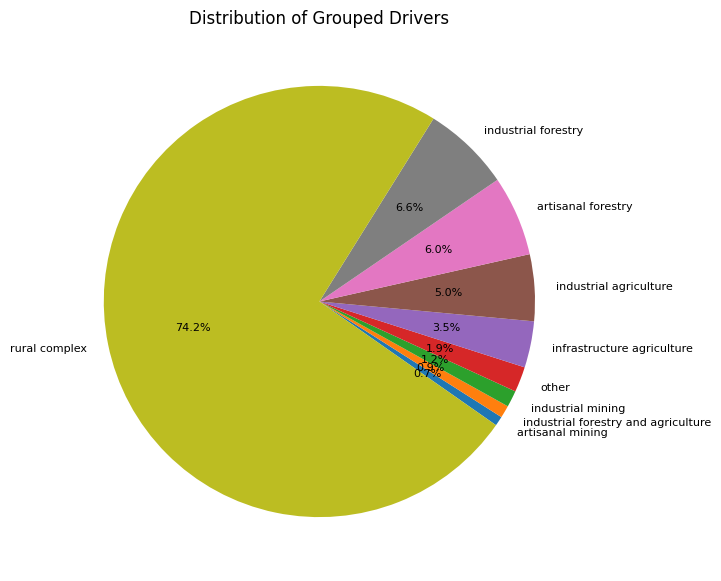

In [76]:
# Filter out blank values
filtered_df = combined_ceo[combined_ceo['GroupedDrivers'] != '']

# Count the occurrences of each value
grouped_counts = filtered_df['GroupedDrivers'].value_counts()

# Sort the counts in descending order
grouped_counts = grouped_counts.sort_values(ascending=True)

# Plot the pie chart with sorted values and smaller text labels
plt.figure(figsize=(10, 7))
plt.pie(
    grouped_counts, 
    labels=grouped_counts.index, 
    autopct='%1.1f%%', 
    startangle=325,
    textprops={'fontsize': 8}  # Adjust the fontsize here
)
# Add a title
plt.title('Distribution of Grouped Drivers')

# Show the plot
plt.show()

In [79]:
columns_to_drop = ['Ref_FNF_2016',
 'Ref_NFtype_2016','Ref_NFtype_2015',
 'Ref_Ftype_2015','Ref_FNF_2015',
 'Ref_LCover_2015',
 'Ref_Ftype_2016','Ref_Change_2023',
 'Ref_Change_Type_2023','TNT_stratum_2023',
 'Ref_NFtype_2022', 'Source',
 'Ref_Change_Year_1520','Ref_Change_Type',
 'Ref_Change_1520','UID',
 'Ref_Ftype_2022',
 'Ref_LCover_2022',
 'Ref_FNF_2022', 'Ref_Change_Year_1522',
 'Ref_Change_LCover_1522',
 'interpreted_qc','Ref_Year_1622',
 'Ref_Change_1622',
 'Ref_Change_Type_1622',
 'Ref_Driver_1622',
 'Ref_Driver2_1622',
 'Ref_Fire2_1622',
 'Ref_Regen_Year',
 'Commentaires',
 'Ref_LCover_2016',
 'Ref_Change_Year_1622',
 'Ref_Change_LCover_1622','Ref_Change_Type_1520', 
 'Province_COD',
 'Province_CMR',
 'Province_COG',
 'Province_CAF',
 'Province_EQG',
 'Province_GAB', 'Ref_Change_1522',
 'Ref_Change_Type_1522',
 'Other_Desc',
 'Ref_Year_1522', 'UID']
# Drop the columns
combined_ceo.drop(columns=columns_to_drop, inplace=True)

In [80]:
combined_ceo['UID'] = range(1, len(combined_ceo) + 1)

In [81]:
len(combined_ceo)

69321

In [82]:
combined_ceo['Ref_Change_Type_1523'].value_counts(dropna=False)

Ref_Change_Type_1523
Stable    35049
NF        27700
Def        4089
Deg        2483
Name: count, dtype: int64

In [83]:
combined_ceo['Ref_Change_Year_1523'].value_counts(dropna=False)

Ref_Change_Year_1523
Stable     35049
NF         27700
Def2017      992
Def2018      961
Def2016      710
Def2019      600
Deg2017      566
Deg2018      482
Deg2016      386
Def2020      360
Deg2019      296
Deg2020      258
Deg2021      195
Def2021      194
Deg2022      177
Def2022      176
Deg2023      123
Def2023       96
Name: count, dtype: int64

In [84]:
combined_ceo['SubAdmin'].value_counts(dropna=False)

SubAdmin
Adamaoua               2386
Haut-Katanga           2231
Nord                   2184
Centre                 2105
Lualaba                1961
Est                    1877
Tanganyka              1810
Haut-Ogooué            1799
Pool                   1635
Ngounié                1500
Cuvette                1422
Litoral Province       1406
Plateaux               1355
Ogooué-Ivindo          1286
Haut-Lomami            1276
Centro Sur Province    1261
Nyanga                 1139
Haute-Kotto            1138
Ogooué-Maritime        1127
Woleu-Ntem             1117
Estuaire               1109
Bas-Uele               1098
Vakaga                 1064
Kwango                 1048
Wele-Nzas Province     1047
Sud-Kivu               1040
Haut-Uele              1035
Niari                  1026
Likouala               1015
Sangha                  912
Kasai                   896
Kwilu                   864
KiÃ©-Ntem Province      813
Moyen-Ogooué            809
Ogooué-Lolo             793
Tshopo     

In [86]:
combined_ceo['GroupedDrivers'].value_counts(dropna=False)

GroupedDrivers
                                       62727
rural complex                           4870
industrial forestry                      432
artisanal forestry                       395
industrial agriculture                   328
infrastructure agriculture               228
other                                    125
industrial mining                         81
industrial forestry and agriculture       61
artisanal mining                          47
NaN                                       27
Name: count, dtype: int64

In [85]:
combined_ceo.to_csv(output_drivers,index_label='ID')